In [1]:
# Import statements
from brian2 import *

# Set font to Arial -- is this working?
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
# Parameter definition
# Simulation
duration = 8*second
defaultclock.dt = 1*ms

# Oscillators
seed(42)
N = [2, 5, 10, 25, 50, 100, 150, 200, 250, 500]
sync = 25
f0 = 6 # center freq [Hz]
sigma = 0.5 # normal std offset for omega

# Input stim
dt_stim = 1*ms
t_stim = 5*second
stim_dur = 100*ms
I0 = 10*amp
tv = linspace(0, duration/second, int(duration/(dt_stim))+1)
xstim = 1. * logical_and(tv>t_stim/second, tv<(t_stim+stim_dur)/second)
pulse_train = TimedArray(xstim*amp**-1, dt=dt_stim)

In [3]:
# Equations
# Kuramoto oscillators
kuramoto_eqs_stim = '''
    dTheta/dt = ((omega + (kN * PIF) - I_stim*X*sin(Theta - pi/2)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    
    ThetaPreInput : 1
    omega : 1 (constant)
    kN : 1 (shared)         # k/N ratio, affects sync.
    I_stim : amp (shared)   # this is the input gain, affects the phase reset aggressiveness
    X = pulse_train(t) : amp**-1 (shared)
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter group calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    test = y : 1
    rhythm_pos = coherence * (sin(phase)+1)/2 : 1
    rhythm_rect = rhythm_pos*nA : amp
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [4]:
# Make the necessary groups
# Oscillators
N_tot = sum(N)
G_K = NeuronGroup(N_tot,
    model=kuramoto_eqs_stim,
    threshold='True',
    method='euler',
    name='Kuramoto_oscillators_N_%d' % N_tot)
#G_K.Theta = '2*pi*rand()' # uniform U~[0,2π]
#G_K.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
theta0 = 2*pi*rand(N_tot) # uniform U~[0,2π]
omega0 = 2*pi*(f0 + sigma*randn(N_tot)) # ~N(2πf0,σ)
G_K.Theta = theta0
G_K.omega = omega0
G_K.kN = sync
G_K.I_stim= I0

# Kuramoto order parameter group
G_pop_avg = NeuronGroup(len(N),
    model=pop_avg_eqs,
    #method='euler',
    name='Kuramoto_averaging')

print('General groups: done')

General groups: done


In [5]:
# Define subgroups
G_all = []
syn_all = []

kuramoto_mon_all = []
order_param_mon_all = []

idx0 = 0
idx1 = 0

for gnum in range(len(N)):
    N_curr = N[gnum]
    
    idx0 = idx1
    idx1 += N_curr
    
    # Subgroups
    G_K_curr = G_K[idx0:idx1]
    G_K_curr.Theta = np.linspace(1e-6, 2*np.pi, G_K_curr.N, endpoint=False)
    
    G_pop_avg_curr = G_pop_avg[gnum]
    r0 = 1/N_curr * sum(exp(1j*G_K_curr.Theta))
    G_pop_avg_curr.x = real(r0)  # avoid division by zero
    G_pop_avg_curr.y = imag(r0)
    
    print(r0)
    print(real(r0), imag(r0))
    print('-------')
    
    G_all.append([G_K_curr, G_pop_avg_curr])    
    
    # Synapses
    syn_kuramoto_curr =  Synapses(G_K_curr, G_K_curr, on_pre=syn_kuramoto_eqs, method='euler', name='Kuramoto_intra_{0}'.format(gnum))
    syn_kuramoto_curr.connect(condition='i!=j')

    syn_avg_curr = Synapses(G_K_curr, G_pop_avg_curr, syn_avg_eqs, name='Kuramoto_avg_{0}'.format(gnum))
    syn_avg_curr.connect()
    
    syn_all.append(syn_kuramoto_curr)
    syn_all.append(syn_avg_curr)

    
    # Monitors
    kuramoto_mon_curr = StateMonitor(G_K_curr, ['Theta'], record=True)
    order_param_mon_curr = StateMonitor(G_pop_avg_curr, ['coherence', 'test', 'phase', 'rhythm', 'rhythm_pos', 'rhythm_rect'], record=True)
    
    kuramoto_mon_all.append(kuramoto_mon_curr)
    order_param_mon_all.append(order_param_mon_curr)
    
print('Subgroups: done')

(-1.8751666885918894e-13+2.500000000262149e-07j)
-1.8751666885918894e-13 2.500000000262149e-07
-------
(-1.3763827108048688e-07+9.999993124676366e-08j)
-1.3763827108048688e-07 9.999993124676366e-08
-------
(-1.5388422811568605e-07+4.999992309073775e-08j)
-1.5388422811568605e-07 4.999992309073775e-08
-------
(-1.58316337275366e-07+1.9999920848334795e-08j)
-1.58316337275366e-07 1.9999920848334795e-08
-------
(-1.5894547884087728e-07+9.999920530523454e-09j)
-1.5894547884087728e-07 9.999920530523454e-09
-------
(-1.5910260764417927e-07+4.999920442116945e-09j)
-1.5910260764417927e-07 4.999920442116945e-09
-------
(-1.5913169832515452e-07+3.3332537441310706e-09j)
-1.5913169832515452e-07 3.3332537441310706e-09
-------
(-1.591418795321431e-07+2.4999204129017018e-09j)
-1.591418795321431e-07 2.4999204129017018e-09
-------
(-1.591465917840651e-07+1.9999204141640804e-09j)
-1.591465917840651e-07 1.9999204141640804e-09
-------
(-1.5915287448819982e-07+9.999204166888376e-10j)
-1.5915287448819982e-07 

In [6]:
# Network
net = Network()
net.add(G_K)
net.add(G_pop_avg)
net.add(G_all)
net.add(syn_all)
net.add(kuramoto_mon_all)
net.add(order_param_mon_all)

In [7]:
# Run the simulation
net.run(duration, report='text', report_period=10*second, profile=True)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the 

Starting simulation at t=0. s for a duration of 8. s
8. s (100%) simulated in 7s


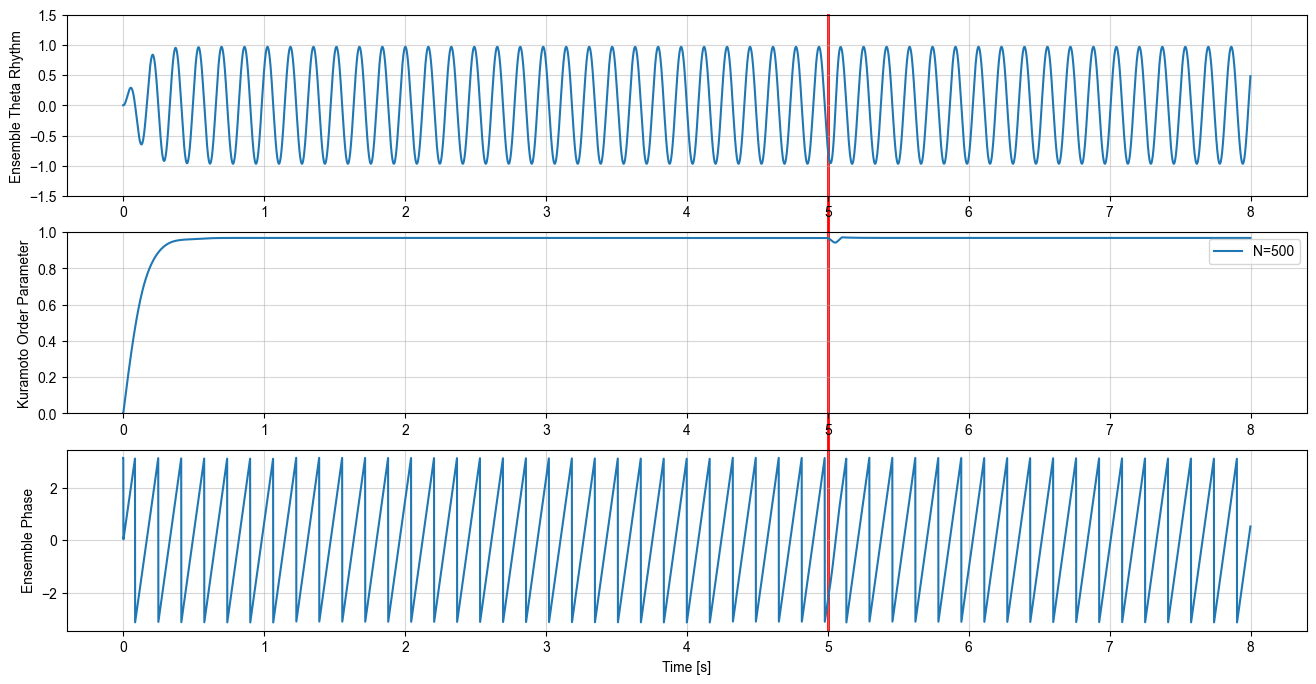

In [8]:
# plot the results
fig, axs = subplots(3,1)
fig.set_figheight(8)
fig.set_figwidth(16)

# for gnum in range(len(N)):
axs[0].plot(order_param_mon_all[-1].t/second, order_param_mon_all[-1].rhythm[0], '-', label='N=%d' % N[gnum])
axs[1].plot(order_param_mon_all[-1].t/second, order_param_mon_all[-1].coherence[0], '-', label='N=%d' % N[gnum])
axs[2].plot(order_param_mon_all[-1].t/second, order_param_mon_all[-1].phase[0], '-', label='N=%d'%N[gnum])    

# Imaginary part of order parameter 1/N Sum ( e^j*theta ) = 1/N Sum Imag{e^j*theta} = 1/N Sum sin(theta)
# This is the normalized (0-1) summed output sine wave!


# labels
axs[0].set_ylabel("Ensemble Theta Rhythm")
axs[1].set_ylabel("Kuramoto Order Parameter")
axs[2].set_ylabel("Ensemble Phase")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylim([-1.5,1.5])
axs[1].set_ylim([0,1])
axs[0].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

# make things pretty
#axs[0].legend()
axs[0].grid(linestyle='-',alpha=0.5)
axs[1].legend()
axs[1].grid(linestyle='-',alpha=0.5)
#axs[2].legend()
axs[2].grid(linestyle='-',alpha=0.5)

# show
fig.savefig('sample.png', facecolor='white', transparent=False)
show()


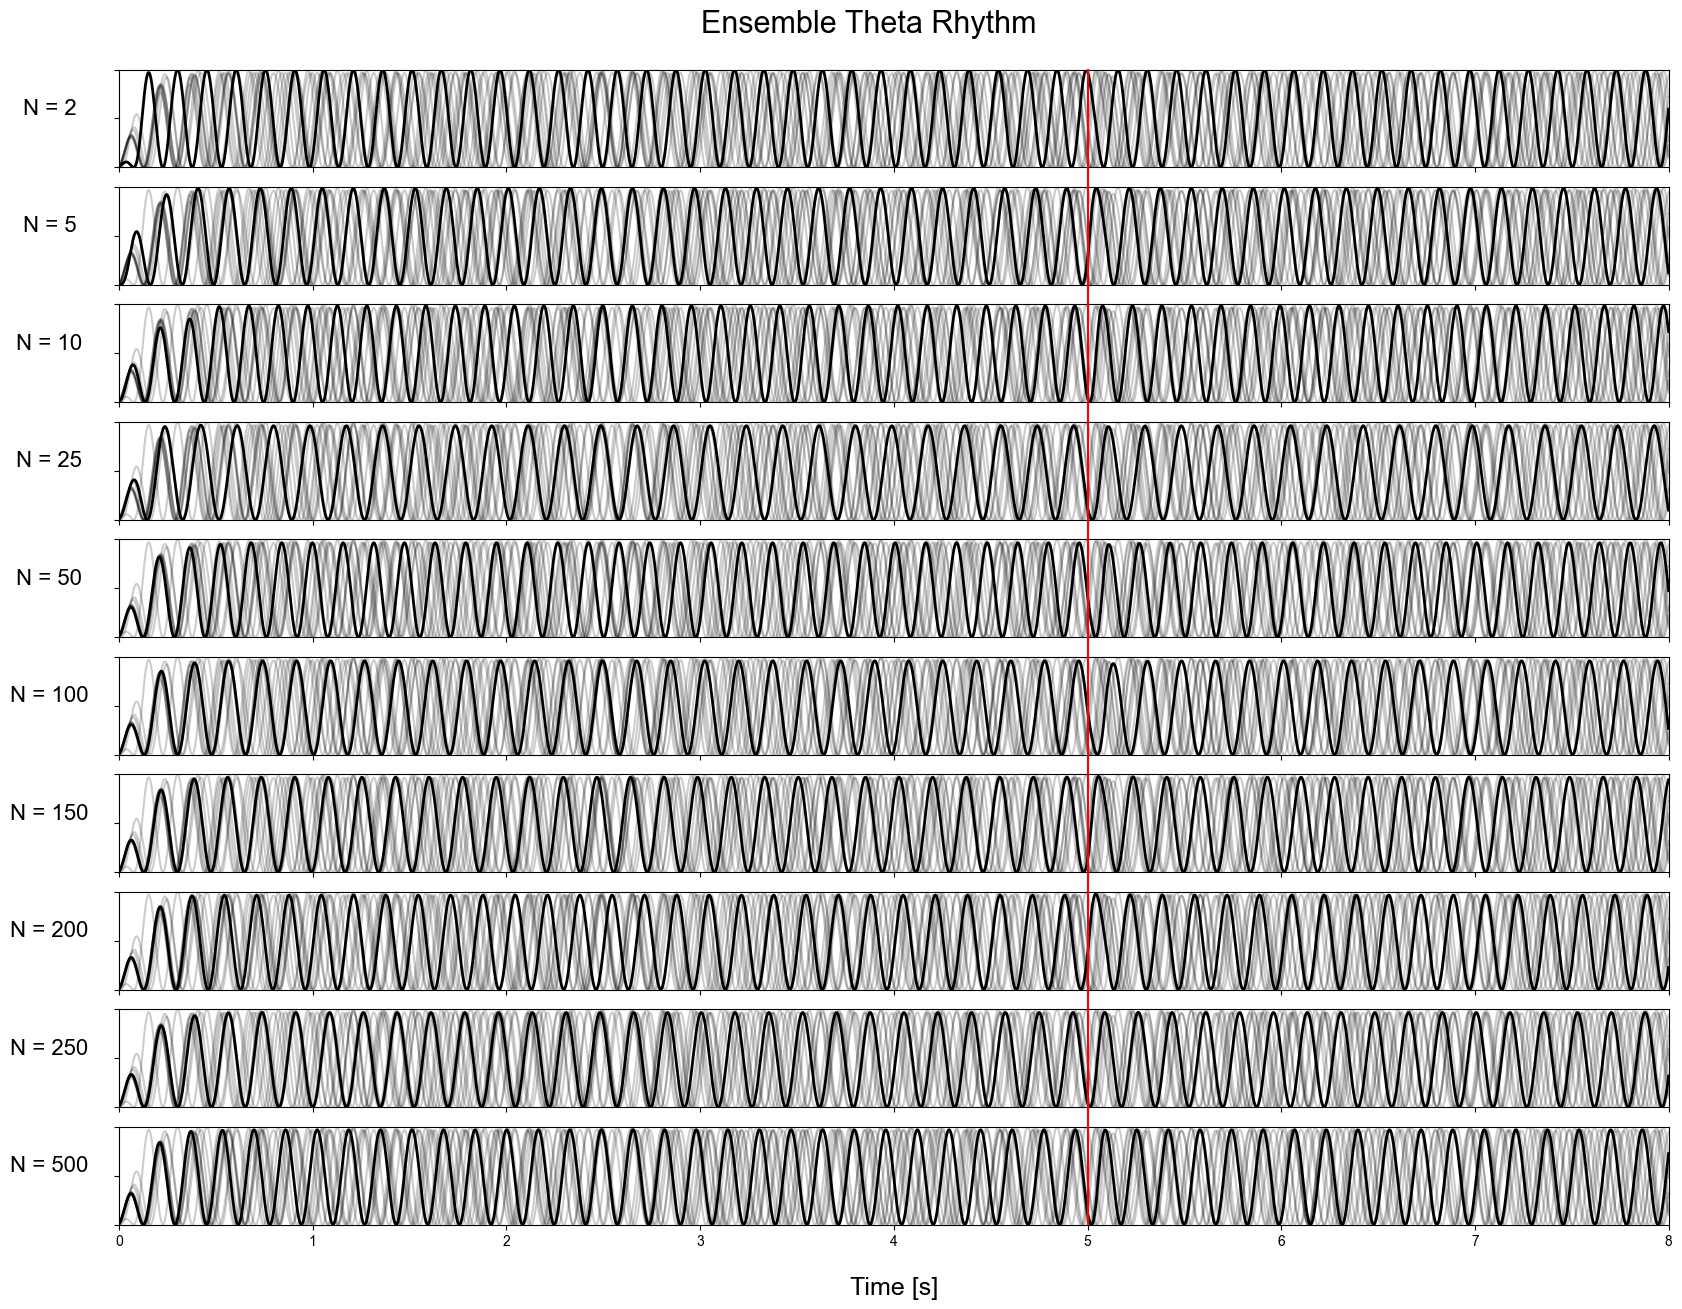

In [9]:
# Avoiding chartjunk [Bottom subplot]
fig, axs = subplots(len(N), figsize=(20,15))

fig.suptitle('Ensemble Theta Rhythm', fontsize=22, y=0.92)

for axnum in range(len(N)):
    for gnum in range(len(N)):
        if axnum == gnum:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].rhythm_pos[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
        else:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].rhythm_pos[0], ls='-', c='k', alpha=0.2, zorder=2)

    axs[axnum].set_ylim([0,1])
    axs[axnum].set_xlim([0,duration])
    axs[axnum].tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=False)
    axs[axnum].set_ylabel('N = %d' % N[axnum], fontsize=16, rotation=0, labelpad=50)
    vline = axs[axnum].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=False)

axs[axnum].set_xlabel('Time [s]', fontsize=18, labelpad=20)
axs[axnum].tick_params(axis='x',
                       which='both',
                       bottom=True,
                       top=False,
                       right=False,
                       left=True,
                       labelbottom=True,
                       labelleft=False)
# clip the last vline
vline.set(clip_on=True)

fig.savefig('Ensemble Theta Rhythm.png', facecolor='white', transparent=False)
plt.show()

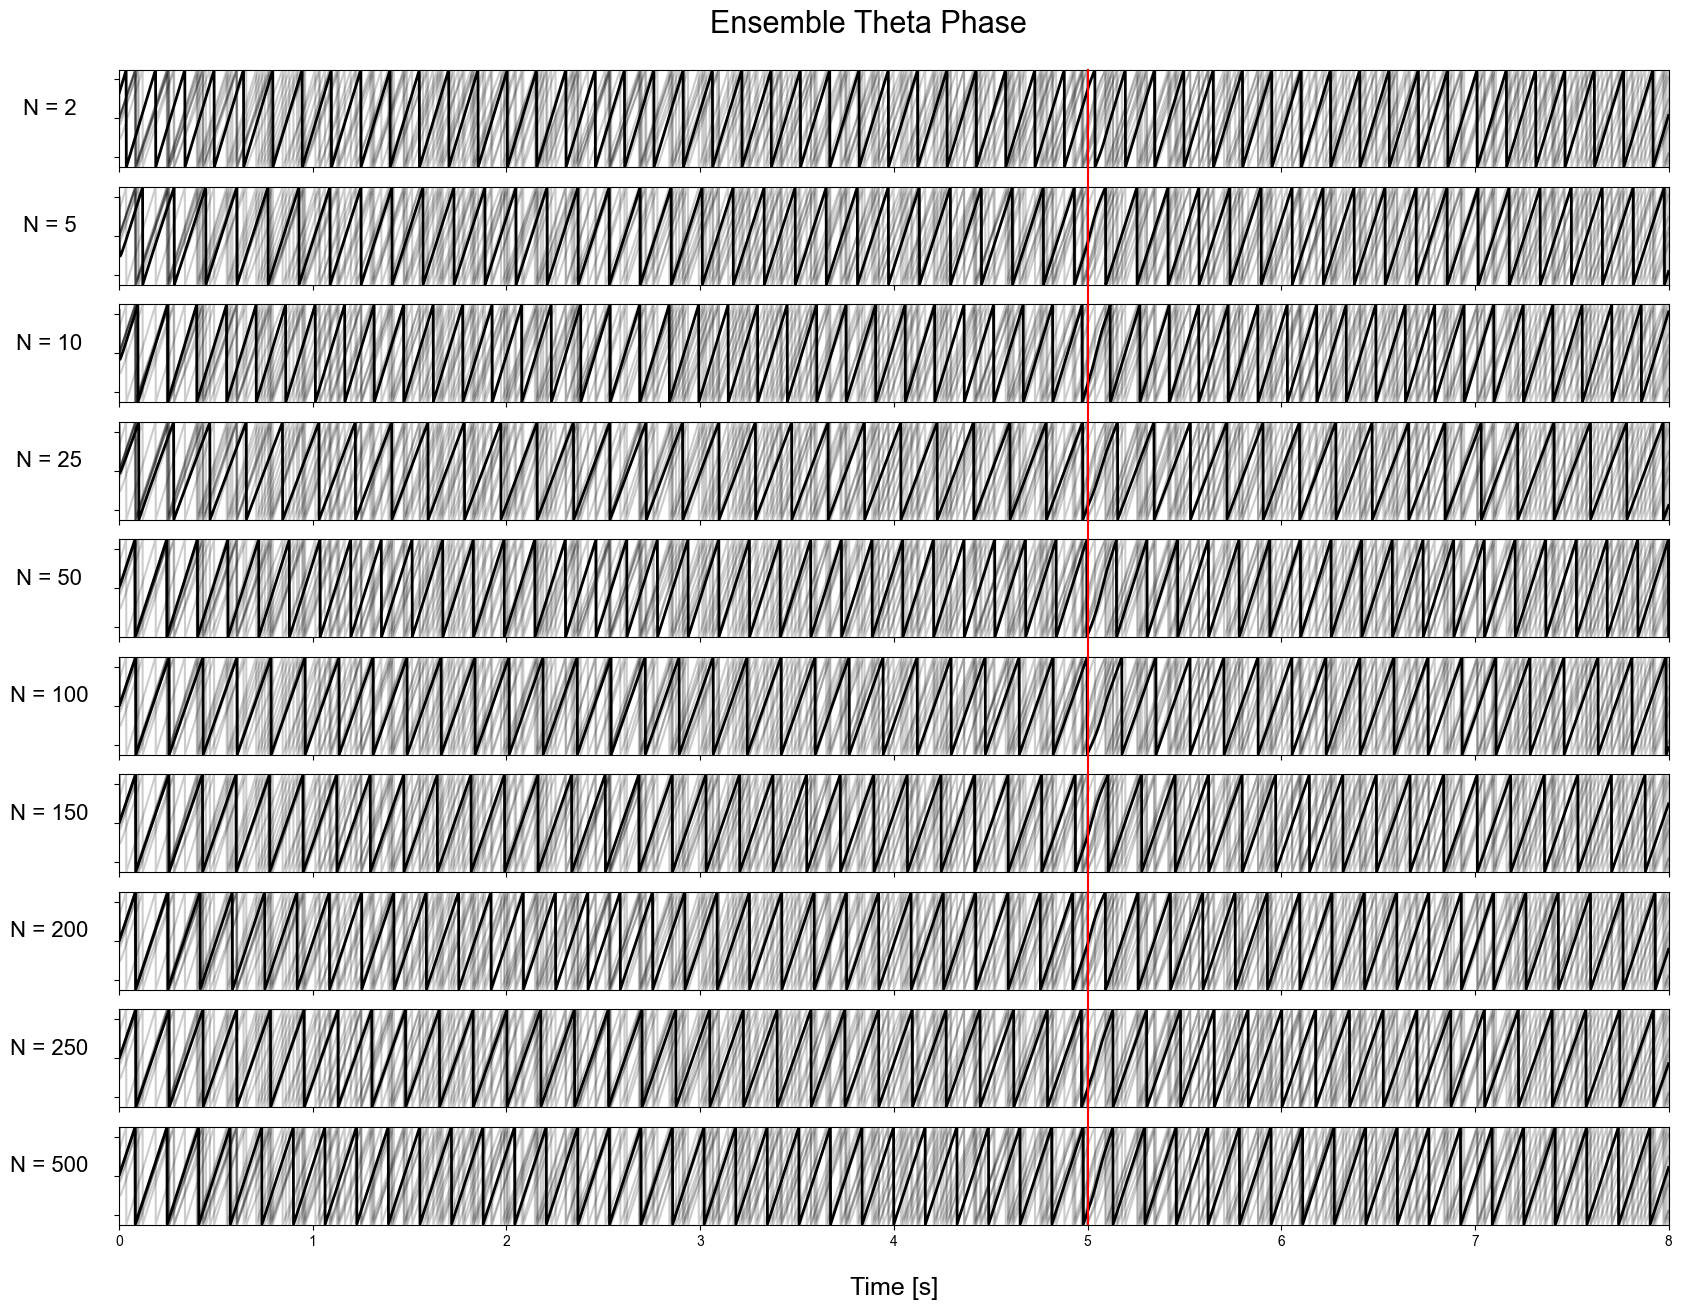

In [10]:
# Avoiding chartjunk [Bottom subplot]
fig, axs = subplots(len(N), figsize=(20,15))

fig.suptitle('Ensemble Theta Phase', fontsize=22, y=0.92)

for axnum in range(len(N)):
    for gnum in range(len(N)):
        if axnum == gnum:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].phase[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
        else:
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].phase[0], ls='-', c='k', alpha=0.2, zorder=2)

    axs[axnum].set_ylim([-pi,pi])
    axs[axnum].set_xlim([0,duration])
    axs[axnum].tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=False)
    axs[axnum].set_ylabel('N = %d' % N[axnum], fontsize=16, rotation=0, labelpad=50)
    vline = axs[axnum].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=False)

axs[axnum].set_xlabel('Time [s]', fontsize=18, labelpad=20)
axs[axnum].tick_params(axis='x',
                       which='both',
                       bottom=True,
                       top=False,
                       right=False,
                       left=True,
                       labelbottom=True,
                       labelleft=False)
# clip the last vline
vline.set(clip_on=True)

fig.savefig('Ensemble Theta Phase.png', facecolor='white', transparent=False)
plt.show()

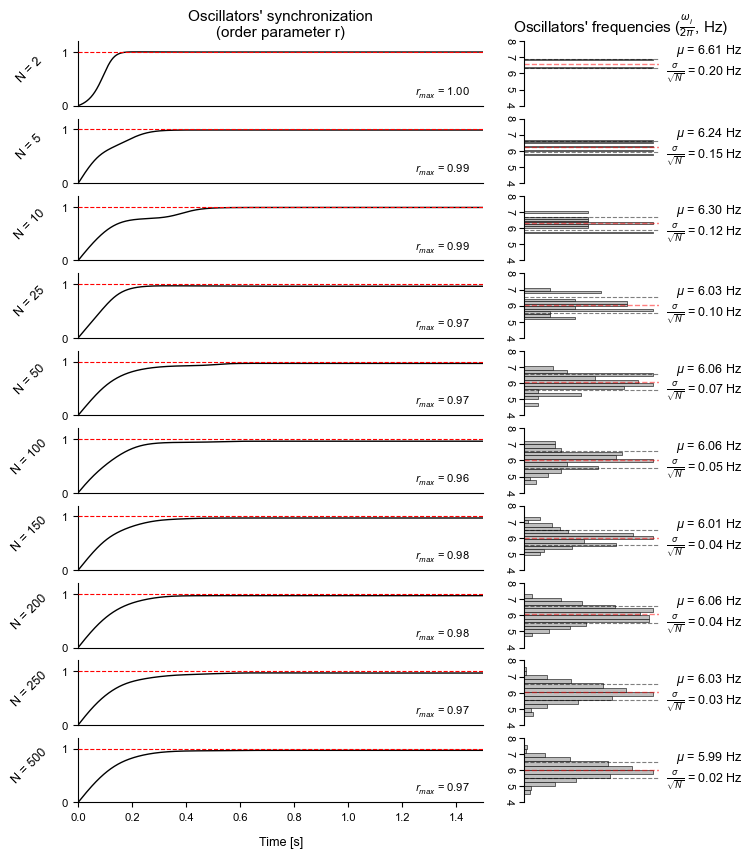

In [47]:
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# ILLUSTRATOR STUFF
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 9

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
})

# Arial font everywhere
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'


# Avoiding chartjunk [Mid subplot]
# fig, axs = subplots(len(N), figsize=(20,15))
fig = plt.figure(constrained_layout=False, figsize=(7.5,8.75))

gs_outer = GridSpec(len(N), 2, left=0.1, right=0.875, bottom=0.08, top=0.95,
                        wspace=0.15, hspace=0.2, width_ratios=(0.75, 0.25))    

# Figure title
# fig.suptitle('Order Parameter', fontsize=22, y=0.92)
# fig.suptitle('Order Parameter', horizontalalignment='right', verticalalignment='top', fontsize=12)
# fig.patch.set_facecolor("black")

# Plot!
axs_op_all = []
for axnum in range(len(N)):
    # Make axes
    ax_op = fig.add_subplot(gs_outer[axnum, 0])
    axs_op_all.append(ax_op)
    
    # Hide spines
    ax_op.spines["right"].set_visible(False)
    ax_op.spines["top"].set_visible(False)
    
    for gnum in range(len(N)):
        if axnum == gnum:
            lab = round(1.-max(order_param_mon_all[gnum].coherence[0]),4)
            ax_op.text(1.35, 0.25, s="$r_{max}$ = "+"{0:.2f}".format(max(order_param_mon_all[gnum].coherence[0])), ha='center', va='center', fontsize=8)
            ax_op.plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].coherence[0], ls='-', linewidth=1, c='k', alpha=1, zorder=3)
        else:
            pass
            # ax_op.plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].coherence[0], ls='-', c='k', alpha=0.15, zorder=2)

    ax_op.set_ylim([0, 1.2])
    ax_op.set_xlim([0, 1.5])
    # ax_op.set_xlim([0,duration])
    ax_op.tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=True,
                           labelsize=8)
    ax_op.set_ylabel('N = %d' % N[axnum], fontsize=9, rotation=45, labelpad=20)
    
    if I0:
        vline = ax_op.axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=True)
    hline = ax_op.axhline(y=1., c='red', ls='--', linewidth=0.8, zorder=3)

for ax in axs_op_all[:-1]:
    ax.set_xticks([])

    # Histograms!
axs_hist_all = []
for axnum in range(len(N)):
    # Make axis
    ax_hist = fig.add_subplot(gs_outer[axnum, 1])
    axs_hist_all.append(ax_hist)
    
    # Make histogram
    H = ax_hist.hist(G_all[axnum][0].omega/(2*np.pi), bins=12, facecolor='0.75', edgecolor='black', linewidth=0.4, orientation='horizontal')

    # Mean and STD
    mu = np.mean(G_all[axnum][0].omega/(2*np.pi))
    std = np.std(G_all[axnum][0].omega/(2*np.pi))
    # print('mean: ', mu, ' std: ', std)

    # Tick params
    ax_hist.tick_params(axis='y',
                  which='both',
                  bottom=False,
                  top=False,
                  right=False,
                  left=True,
                  labelbottom=False,
                  labelleft=True)

    # Tick labels
    ax_hist.set_xticks([])
    ax_hist.set_yticks(np.arange(0,10,1))
    # ax_hist.set_yticks([mu-std, mu, mu+std])
    # ax_hist.set_yticklabels(['', str(np.round(mu,1)), ' '], rotation=-90)
    ax_hist.set_yticklabels(ax_hist.get_yticks(), rotation = -90, fontsize=8)

    # Lines for mu/std
    ax_hist.axhline(y=mu, xmin=0, xmax=100, ls='--', linewidth=1.0, alpha=0.5, c='red', clip_on=True)
    ax_hist.axhline(y=mu-std, xmin=0, xmax=100, ls='--', linewidth=0.8, alpha=0.5, c='k', clip_on=True)
    ax_hist.axhline(y=mu+std, xmin=0, xmax=100, ls='--', linewidth=0.8, alpha=0.5, c='k', clip_on=True)

    # Limits
    val = 4
    # print([2*np.pi*(f0-val*sigma), 2*np.pi*(f0+val*sigma)])
    # ax_hist.set_ylim([2*np.pi*(f0-val*sigma), 2*np.pi*(f0+val*sigma)])
    ax_hist.set_ylim([f0-val*sigma, f0+val*sigma])
    
    # Title
    # ax_hist.set_title('$\mu$={0:.2f} Hz, $\sigma$={1:.2f} Hz'.format(mu/(2*np.pi), std/(2*np.pi)), fontsize=9)
    # print(H[0].max())
    ax_hist.text(x=1.1*H[0].max(), y=mu, transform=ax_hist.transData, rotation=0, va='center', ha='left', s='   $\mu$ = {0:.2f} Hz\n'.format(mu)+r'$\frac{\sigma}{\sqrt{N}}$'+' = {0:.2f} Hz'.format((std/sqrt(N[axnum]))), fontsize=9)
    
    # Spines
    ax_hist.spines["right"].set_visible(False)
    ax_hist.spines["bottom"].set_visible(False)
    ax_hist.spines["top"].set_visible(False)

# axs_op_all[-2].set_facecolor('#DCDCDC')
ax_op.set_xlabel('Time [s]', labelpad=10)
ax_op.tick_params(axis='x',
                  which='both',
                  bottom=True,
                  top=False,
                  right=False,
                  left=True,
                  labelbottom=True,
                  labelleft=False)
# clip the last vline
vline.set(clip_on=True)

# Set figure titles
# axs_op_all[0].set_title(r'$Order$ $\bf{Parameter}$', pad=23, horizontalalignment='center', verticalalignment='top', fontsize=11)
axs_op_all[0].set_title("Oscillators\' synchronization\n(order parameter r)", pad=23, horizontalalignment='center', verticalalignment='top', fontsize=11)
axs_hist_all[0].set_title(r"              Oscillators' frequencies ($\frac{\omega_i}{2\pi}$, Hz) ", pad=20, horizontalalignment='center', verticalalignment='top', fontsize=11)

# yticks for axs_op
# axs_op_all[0].set_yticks(np.arange(0,2))
# axs_op_all[0].set_yticklabels(axs_op_all[0].get_yticklabels())
# axs_op_all[0].tick_params(axis='y',       # changes apply to both axes
#                            which='both',      # both major and minor ticks are affected
#                            labelleft=True,
#                            labelsize=8)

fig.savefig('Order Parameter.png', facecolor='white', dpi=300, transparent=True, format='png')
fig.savefig('Order Parameter.pdf', facecolor='white', dpi=300, transparent=True, format='pdf')
plt.show()